<a href="https://colab.research.google.com/github/geotrush/Neural-Network-Zoo/blob/main/Fast%20Neural%20Style%20Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Style Transfer
----------------------------
### Paper: [Perceptual Losses for Real-Time Style Transfer and Super-Resolution (Johnson et al., 2015)](https://arxiv.org/pdf/1603.08155.pdf)

Import libraries.

In [ ]:
# Notebook display
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm_notebook

# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CocoDetection
from torch.hub import load_state_dict_from_url
from torch.utils.data import DataLoader, Dataset
from torch.nn.init import kaiming_normal_, constant_
from torch.nn import Module, Sequential, ReflectionPad2d, Conv2d, InstanceNorm2d, AvgPool2d, ReLU

Define constants and image processing functions.

In [ ]:
# Image size
SIZE = 1024

# ImageNet statistics
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, normalize=True, mean=MEAN, std=STD):
    resize = transforms.Compose([transforms.Resize(SIZE, Image.LANCZOS),
                                 transforms.CenterCrop(SIZE)])
    norm = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean, std)])
    image = resize(image)
    if normalize:
        return norm(image).unsqueeze(0).to(DEVICE)
    return image

# Post-processing
def post(tensor, mean=MEAN, std=STD):
    mean, std = torch.tensor(mean).view(3, 1, 1), torch.tensor(std).view(3, 1, 1)
    tensor = transforms.Lambda(lambda x: x * std + mean)(tensor.cpu().clone().squeeze(0))
    return transforms.ToPILImage()(tensor.clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image, normalize=False))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image, normalize=False))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

Load content and style images.

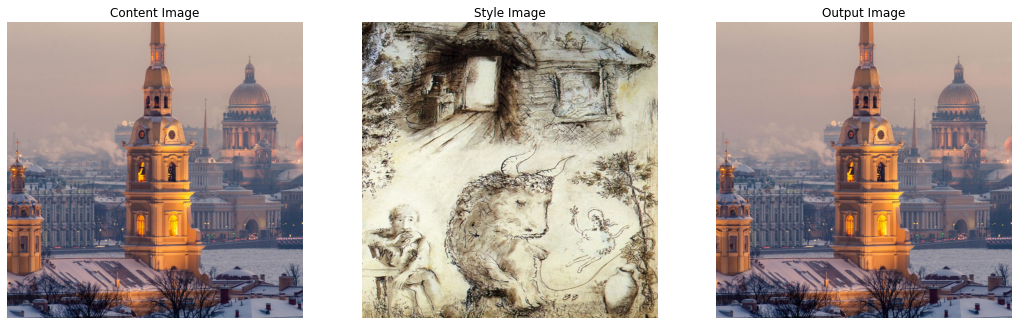

In [ ]:
# Manually upload the images
files.upload()
clear_output()

# Open and prepare images
content_image, style_image = Image.open('peter and paul fortress.jpg'), Image.open('tale of tales.jpg')
input, style = prep(content_image), prep(style_image)

# Display images
_ = draw(input, content_image, style_image)

Define content and style losses.

In [ ]:
class ContentLoss(Module):
    def forward(self, features, targets):
        loss = (features - targets).pow(2)
        return loss.mean()


class StyleLoss(Module):
    def forward(self, features, GM_t):
        GM_f = self.gram_matrix(features)
        loss = (GM_f - GM_t).pow(2)
        return loss.mean()
    
    @staticmethod
    def gram_matrix(inputs):
        BS, C, H, W = inputs.size()
        inputs = inputs.view(BS, C, H * W)
        GM = inputs.bmm(inputs.transpose(1, 2))
        return GM.div_(H * W)

Image Transformation Network (with nearest neighbour upsampling instead of transposed convolutions for better performance).

In [ ]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None, activation=True):
        super().__init__()
        
        self.upsample = upsample
        self.activation = activation
        self.conv_block = Sequential(ReflectionPad2d(kernel_size // 2),
                                     Conv2d(in_channels, out_channels, kernel_size, stride),
                                     InstanceNorm2d(out_channels, affine=True))

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=self.upsample)
        if self.activation:
            conv = F.relu(self.conv_block(x))
        else:
            conv = self.conv_block(x)
        return conv


class ResidualBlock(Module):
    def __init__(self, channels):
        super().__init__()
        
        self.conv_block1 = ConvBlock(channels, channels, kernel_size=3, stride=1)
        self.conv_block2 = ConvBlock(channels, channels, kernel_size=3, stride=1, activation=False)

    def forward(self, x):
        identity = x
        conv = self.conv_block2(self.conv_block1(x))
        conv += identity
        return conv


class TransformationNet(Module):
    def __init__(self):
        super().__init__()

        # Convolutional Blocks
        self.conv_blocks = Sequential(ConvBlock(3, 32, kernel_size=9, stride=1), 
                                      ConvBlock(32, 64, kernel_size=3, stride=2),
                                      ConvBlock(64, 128, kernel_size=3, stride=2))

        # Residual Blocks
        self.res_blocks = Sequential(ResidualBlock(128),
                                    ResidualBlock(128),
                                    ResidualBlock(128),
                                    ResidualBlock(128),
                                    ResidualBlock(128))

        # Upsampling Blocks
        self.deconv_blocks = Sequential(ConvBlock(128, 64, kernel_size=3, stride=1, upsample=2),
                                        ConvBlock(64, 32, kernel_size=3, stride=1, upsample=2),
                                        ConvBlock(32, 3, kernel_size=9, stride=1, activation=False))

        # Weight Initialization
        for module in self.modules():
            if isinstance(module, Conv2d):
                kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                constant_(module.bias, 0)
            elif isinstance(module, InstanceNorm2d):
                constant_(module.weight, 1)
                constant_(module.bias, 0)

    def forward(self, x):
        conv = self.conv_blocks(x)
        res = self.res_blocks(conv)
        deconv = self.deconv_blocks(res)
        return deconv

VGG-16 (with average pooling for better image synthesis).

Paper: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)

In [ ]:
class VGG16(Module):
    def __init__(self):
        super().__init__()

        # Feature Extractor
        self.conv1_1 = Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv2_1 = Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv3_1 = Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv4_1 = Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 =   AvgPool2d(kernel_size=2, stride=2)
            
        self.conv5_1 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 =   AvgPool2d(kernel_size=2, stride=2)
        
        # Freeze Parameters
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x, out_layers):
        out = dict()
        
        out['conv1_1'] = F.relu(self.conv1_1(x))
        out['conv1_2'] = F.relu(self.conv1_2(out['conv1_1']))
        out['pool1'] = self.pool1(out['conv1_2'])

        out['conv2_1'] = F.relu(self.conv2_1(out['pool1']))
        out['conv2_2'] = F.relu(self.conv2_2(out['conv2_1']))
        out['pool2'] = self.pool2(out['conv2_2'])

        out['conv3_1'] = F.relu(self.conv3_1(out['pool2']))
        out['conv3_2'] = F.relu(self.conv3_2(out['conv3_1']))
        out['conv3_3'] = F.relu(self.conv3_3(out['conv3_2']))
        out['pool3'] = self.pool3(out['conv3_3'])

        out['conv4_1'] = F.relu(self.conv4_1(out['pool3']))
        out['conv4_2'] = F.relu(self.conv4_2(out['conv4_1']))
        out['conv4_3'] = F.relu(self.conv4_3(out['conv4_2']))
        out['pool4'] = self.pool4(out['conv4_3'])

        out['conv5_1'] = F.relu(self.conv5_1(out['pool4']))
        out['conv5_2'] = F.relu(self.conv5_2(out['conv5_1']))
        out['conv5_3'] = F.relu(self.conv5_3(out['conv5_2']))
        out['pool5'] = self.pool5(out['conv5_3'])

        return [out[layer] for layer in out_layers]

Initialize networks and load pre-trained weights.

In [ ]:
vgg16 = VGG16().to(DEVICE)
transnet = TransformationNet().to(DEVICE)

state = vgg16.state_dict()
pretrained_vgg16 = 'https://download.pytorch.org/models/vgg16-397923af.pth'
new_state_values = list(load_state_dict_from_url(pretrained_vgg16).values())

for i, value in enumerate(state):
    state[value] = new_state_values[i]

vgg16.load_state_dict(state)

Load MS-COCO 2014 Train Dataset and train the ImageTransformationNet.

In [ ]:
# MS-COCO 2014 Train Dataset
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip annotations_trainval2014
!unzip train2014

# Image transforms
image2tensor = transforms.Compose([transforms.Resize(256, Image.LANCZOS),
                                   transforms.CenterCrop(256),
                                   transforms.ToTensor(),
                                   transforms.Normalize(MEAN, STD)])

# Train dataset and dataloader
train_dataset = CocoDetection('train2014', 'annotations/instances_train2014.json', image2tensor)
train_loader = DataLoader(train_dataset, batch_size=4, collate_fn=lambda batch: torch.stack([x[0] for x in batch]))
clear_output()

Pre-compute targets and initialize losses.

In [ ]:
# Layers of content/style reconstruction
content_layers = ['conv2_2']
style_layers = ['conv1_2', 'conv2_2', 'conv3_3', 'conv4_3']
num_style_layers = len(style_layers)

# Style targets
style_tensors = style.repeat(4, 1, 1, 1)
style_targets = [StyleLoss.gram_matrix(target) for target in vgg16(style_tensors, style_layers)]

# Loss functions
content_loss_fn = ContentLoss()
style_loss_fn = StyleLoss()

# Loss weights
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e3
TV_WEIGHT = 1e-6

Training loop.

In [ ]:
def train(transnet, train_loader, style_targets, content_loss_fn, style_loss_fn, epochs=2):
    num_batches = len(train_loader)
    optimizer = Adam(transnet.parameters(), lr=1e-3)

    for epoch in trange(epochs, desc='Epochs'):
        batches = iter(train_loader)
        for batch_idx in tqdm_notebook(range(num_batches), desc='Batches', leave=False):
            batch = next(batches).to(DEVICE)
            images_in_batch = len(batch)

            optimizer.zero_grad()
            vgg16_out = vgg16(batch, content_layers)
            transnet_out = transnet(batch)
            vgg16_transnet_out = vgg16(transnet_out, style_layers)

            # Content Loss
            content_preds, content_targets = vgg16_transnet_out[1], vgg16_out[0]
            content_loss = CONTENT_WEIGHT * content_loss_fn(content_preds, content_targets)
            
            # Style Loss
            style_loss = 0
            for i in range(num_style_layers):
                style_loss += style_loss_fn(vgg16_transnet_out[i], style_targets[i][:images_in_batch])
            style_loss *= STYLE_WEIGHT
            
            # Total Variation Regularization
            diff_i = ((transnet_out[:, :, :, 1:] - transnet_out[:, :, :, :-1]).abs()).sum()
            diff_j = ((transnet_out[:, :, 1:, :] - transnet_out[:, :, :-1, :]).abs()).sum()
            tv_reg = TV_WEIGHT * (diff_i + diff_j)

            total_loss = style_loss + content_loss + tv_reg
            total_loss.backward()
            optimizer.step()
            
    # Save the trained weights
    torch.save(transnet.state_dict(), 'transnet.pt')

# Run
train(transnet, train_loader, style_targets, content_loss_fn, style_loss_fn)

Buffered data was truncated after reaching the output size limit.

Transfer style.

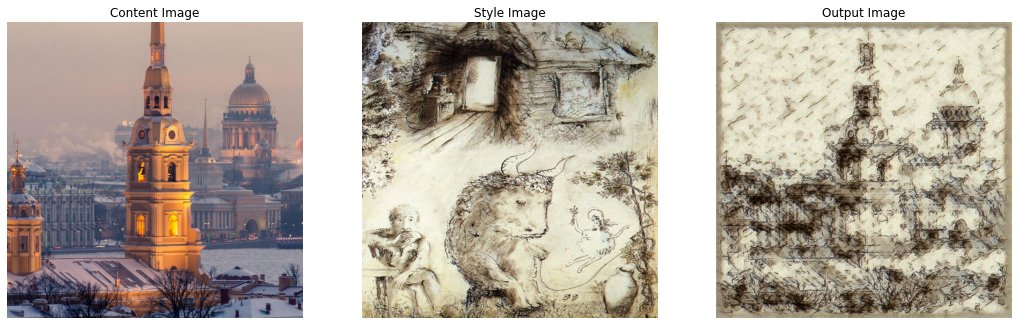

In [ ]:
def transfer_style(transnet, input):
    transnet.eval()
    with torch.no_grad():
        output = draw(transnet(input), content_image, style_image)
    return output

# Run
transnet.load_state_dict(torch.load('transnet.pt'))
output = transfer_style(transnet, input)

Save and download output.

In [ ]:
output.save('output.png')
files.download('output.png')